# 01 - Image Preprocessing

## Übersicht 
Hier wird versucht die vorgebenen Rohbilder auf die Vearbeitung zu vorbereiten. Es würden folgende Ansätze versucht:

1. **Grayscale Conversion** - RGB → Graustufen
2. **Noise Reduction** - Gaussian Blur
3. **Thresholding** - Graustufen → Binär (0/255)
4. **Morphological Operations** - Artefakte entfernen


### Installation von packages

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

### Bild laden

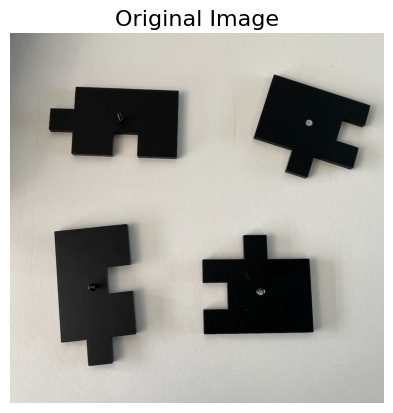

Shape: (941, 951, 3)


In [6]:
image_path = '../data/image-003.png'
image = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image', fontsize=16)
plt.axis('off')
plt.show()

print(f'Shape: {image.shape}')

### 1. Grayscale Conversion

Da viele Algorithmen auf Graustufenbilder arbeiten, da sie auf intensitätsbasiert Informationen stammen.

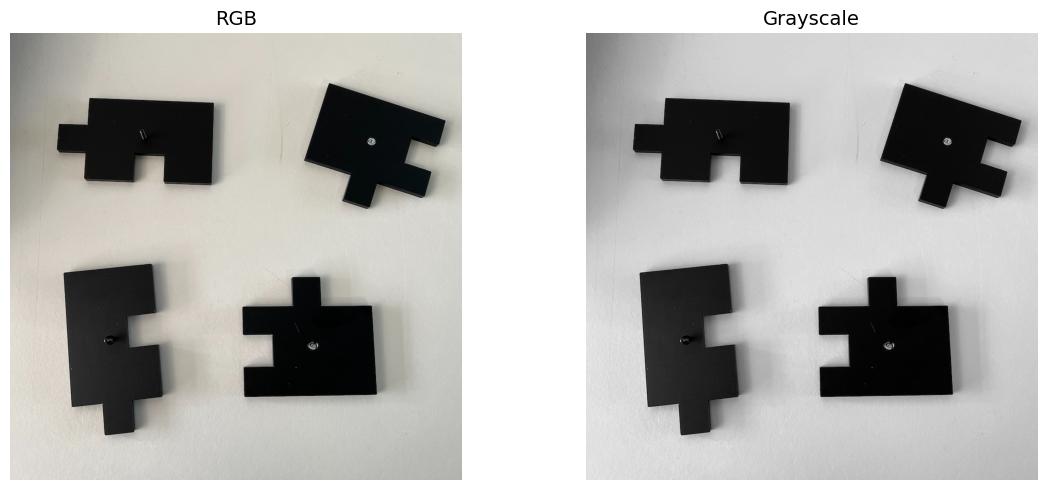

In [7]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('RGB', fontsize=14)
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Grayscale', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 2. Noise Reduction - Gaussian Blur

Bei der Noise Reduction haben wir festgestellt dass Gaussian Blur wird bevorzugt, weil er Rauschen effektiv glättet, ohne Kanten stark zu verzerren, und weil seine gaussförmige Gewichtung ein natürliches, artefaktfreies Ergebnis liefert, das optimal für weitere Bildverarbeitungsschritte ist. Zudem wurde festgestellt beim Detailgehalt auf 5x5 (Default) zu bleiben, da es eine Ausgewogene Glättung zurückgibt.

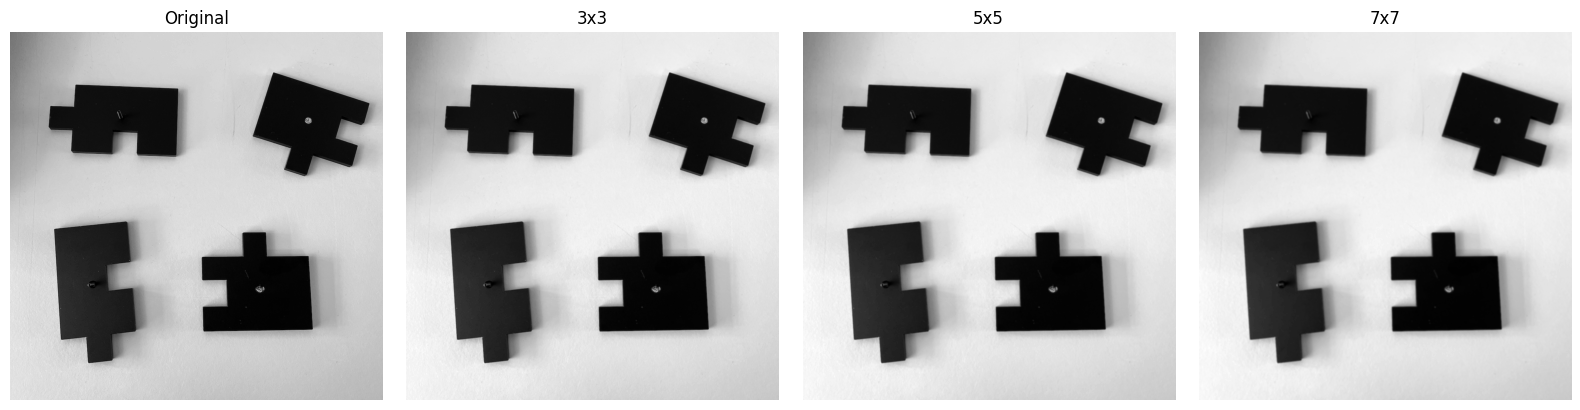

In [9]:
blur_3 = cv2.GaussianBlur(gray, (3, 3), 0)
blur_5 = cv2.GaussianBlur(gray, (5, 5), 0)
blur_7 = cv2.GaussianBlur(gray, (7, 7), 0)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original')
axes[1].imshow(blur_3, cmap='gray')
axes[1].set_title('3x3')
axes[2].imshow(blur_5, cmap='gray')
axes[2].set_title('5x5')
axes[3].imshow(blur_7, cmap='gray')
axes[3].set_title('7x7')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### 3. Thresholding
Beim Thresholding trennt man das Bild in Vorder- und Hintergrund, wobei sich zeigt, dass ein fixer Wert oft unzuverlässig ist, da er stark von der Beleuchtung abhängt. Otsu’s Methode liefert hier meist bessere Ergebnisse, weil sie den optimalen Schwellwert automatisch aus dem Histogramm bestimmt. Für Bereiche mit ungleichmäßiger Helligkeit eignet sich zudem das adaptive Thresholding, das lokale Schwellen berechnet und dadurch auch feine Strukturen stabil erfasst.

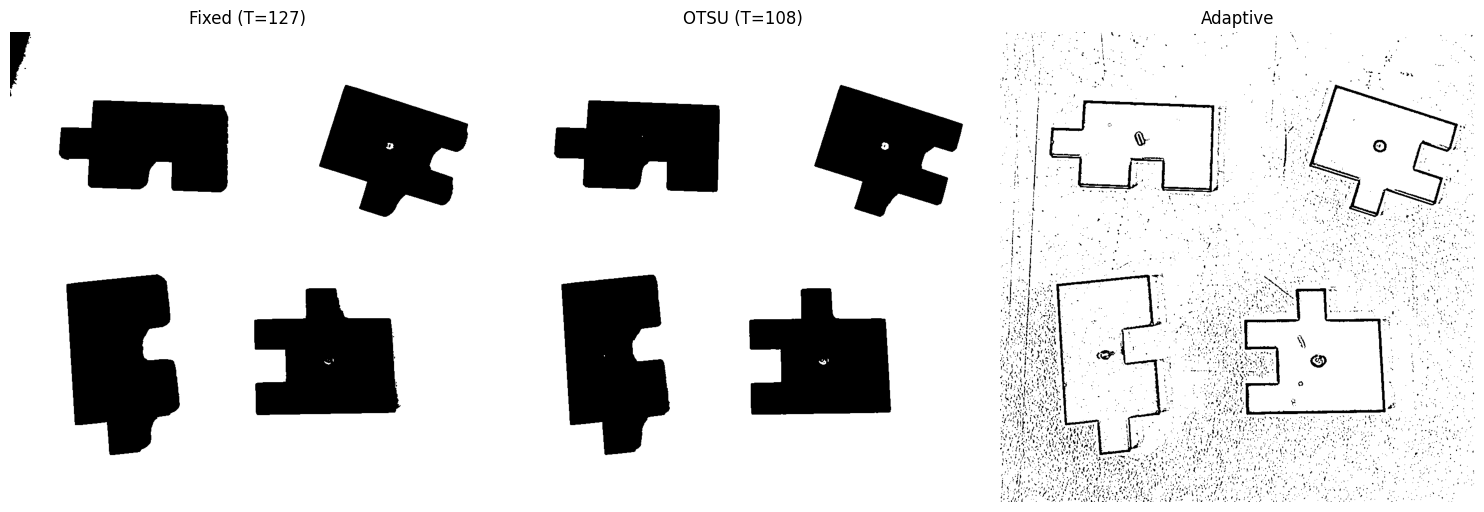

OTSU auto-selected threshold: 108.0


In [14]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

_, thresh_fixed = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
otsu_val, thresh_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh_adaptive = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(thresh_fixed, cmap='gray')
axes[0].set_title('Fixed (T=127)')
axes[1].imshow(thresh_otsu, cmap='gray')
axes[1].set_title(f'OTSU (T={otsu_val:.0f})')
axes[2].imshow(thresh_adaptive, cmap='gray')
axes[2].set_title('Adaptive')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'OTSU auto-selected threshold: {otsu_val:.1f}')

### 4. Morphological Operations
Morphological Operations helfen dabei, die binäre Maske weiter zu bereinigen: Opening entfernt kleine helle Störpunkte, während Closing kleine dunkle Lücken füllt. Für besonders unruhige Masken kann eine Kombination aus Opening + Closing ein sehr sauberes Ergebnis liefern. In unserem Fall wurde die finale Kombination jedoch nicht verwendet, weil sie die Puzzle-Kontur leicht glättete und dadurch feine Details an den Kanten verloren gingen – was für die spätere Formanalyse unerwünscht gewesen wäre.

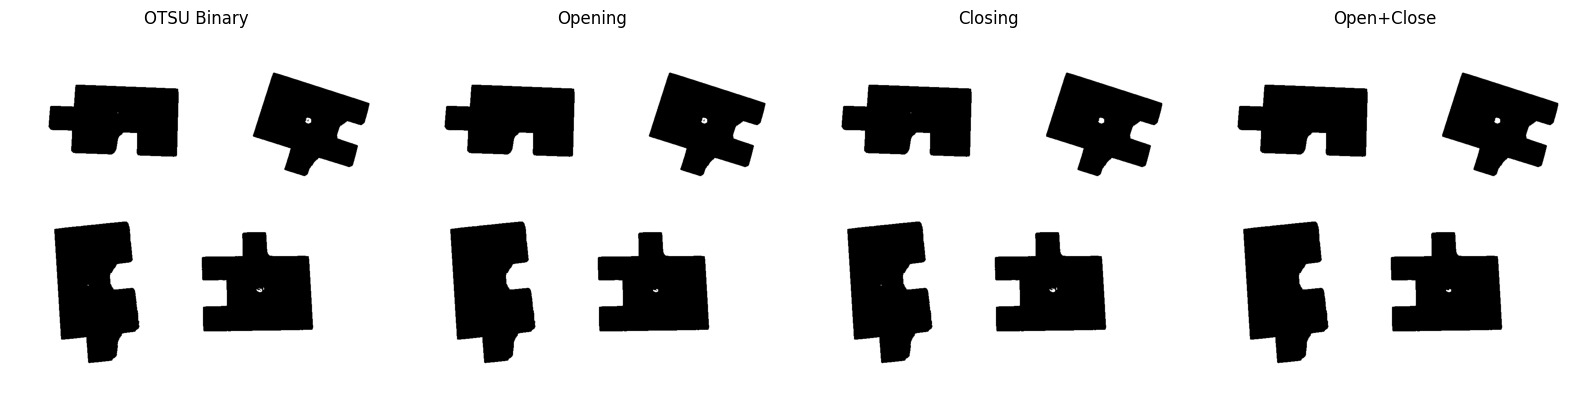

In [18]:
kernel = np.ones((3, 3), np.uint8)

opened = cv2.morphologyEx(thresh_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
closed = cv2.morphologyEx(thresh_otsu, cv2.MORPH_CLOSE, kernel, iterations=1)
final = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(thresh_otsu, cmap='gray')
axes[0].set_title('OTSU Binary')
axes[1].imshow(opened, cmap='gray')
axes[1].set_title('Opening')
axes[2].imshow(closed, cmap='gray')
axes[2].set_title('Closing')
axes[3].imshow(final, cmap='gray')
axes[3].set_title('Open+Close')

for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### 5. Adaptive Threshold für dunkles Material (PMMA Carbon)
Für dunkle Materialien wie PMMA Carbon, das matt und lichtschluckend ist, stößt Otsu's Methode an ihre Grenzen, da das Histogramm keinen klaren bimodalen Kontrast aufweist. Die Kombination aus CLAHE und adaptivem Thresholding bietet hier einen robusteren Ansatz: Verstärkt zunächst lokal den Kontrast, während das adaptive Thresholding anschließend mit lokalen Schwellwerten arbeitet und so auch bei ungleichmäßiger Beleuchtung zuverlässige Ergebnisse liefert. 

Da aktuell nur ein Simulator umgesetzt wird, ist diese Methode nicht sinnvoll testbar – sie wurde jedoch als vielversprechende Option für den späteren Einsatz mit echtem PMMA Carbon dokumentiert

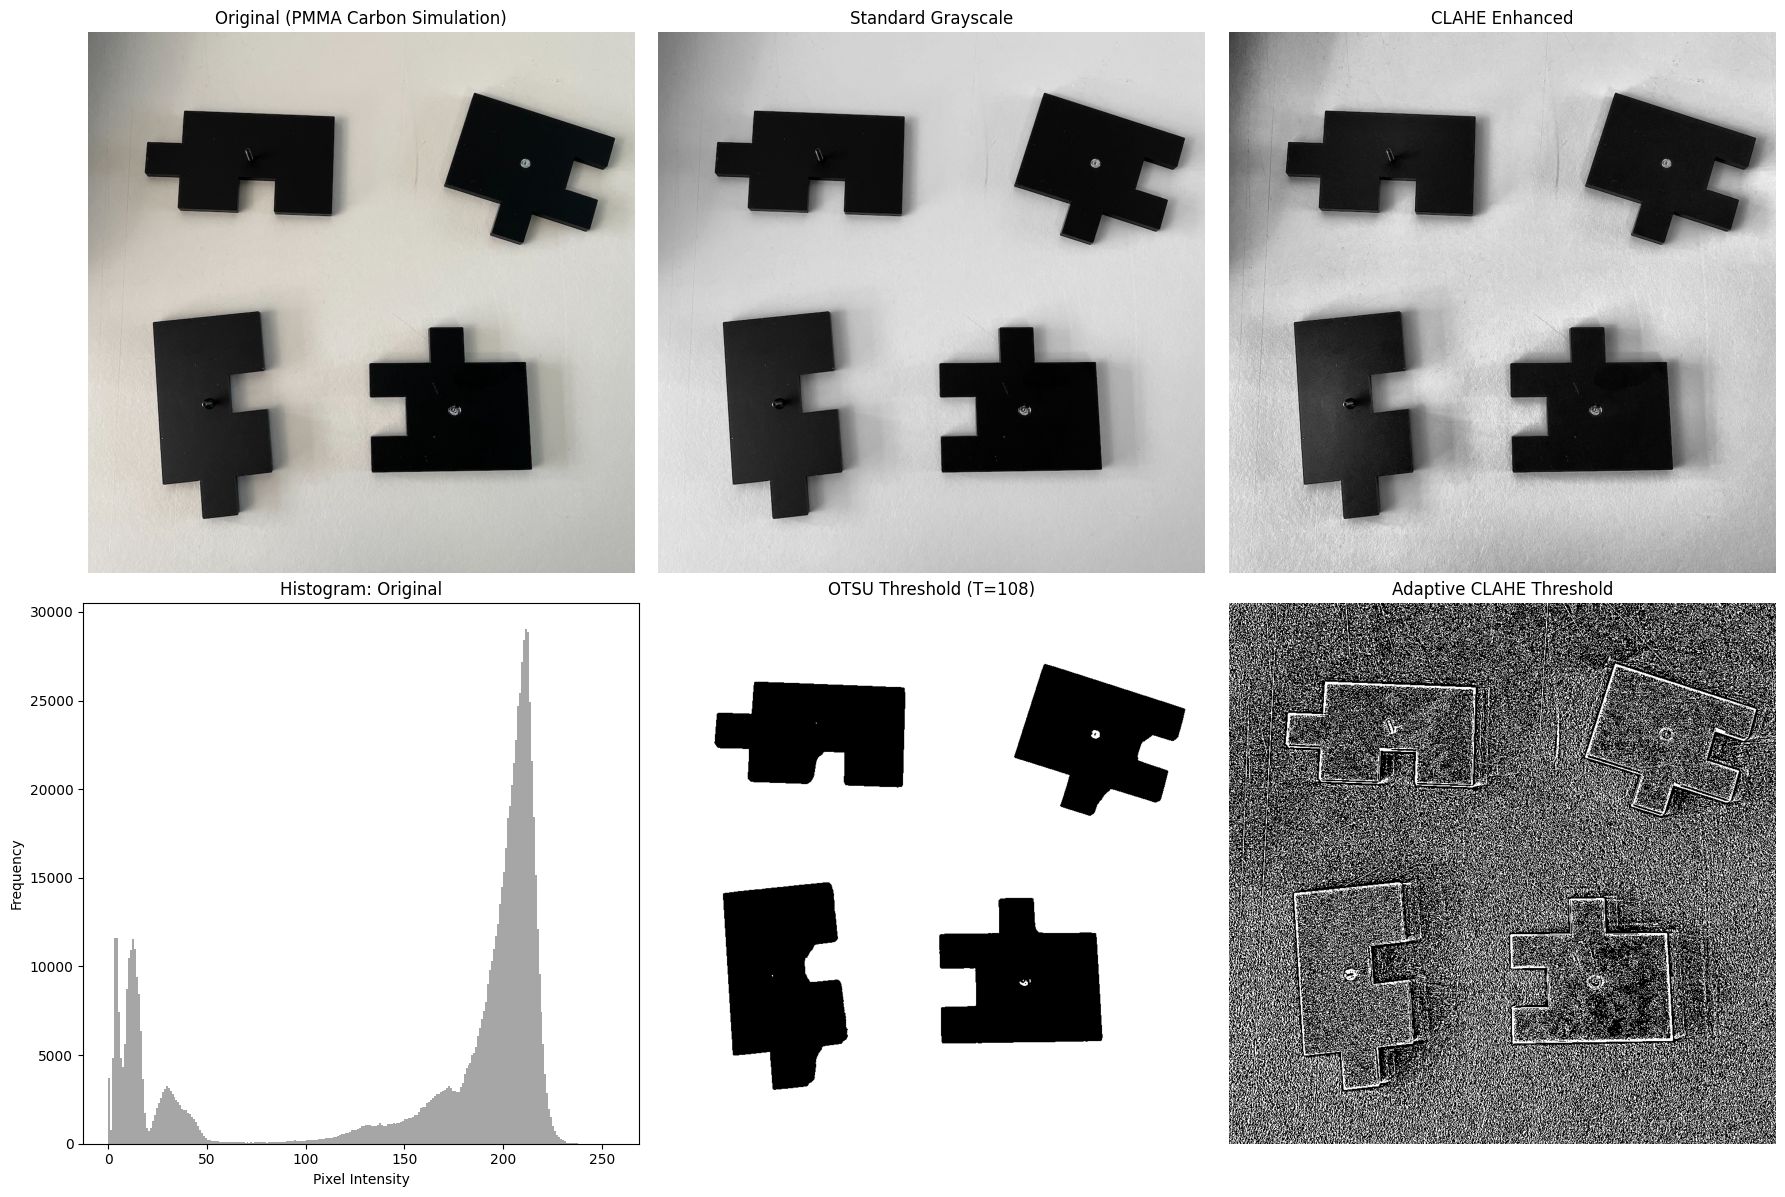

In [20]:
def adaptive_threshold_clahe(image, clip_limit=2.0, block_size=11):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # CLAHE: Kontrastverstärkung
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    # Adaptive Threshold
    binary = cv2.adaptiveThreshold(
        enhanced, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=block_size,
        C=2
    )
    
    return binary, enhanced

# Anwendung
adaptive_binary, enhanced_gray = adaptive_threshold_clahe(image)

# Vergleich: OTSU vs Adaptive CLAHE
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title('Original (PMMA Carbon Simulation)', fontsize=12)
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Standard Grayscale', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced_gray, cmap='gray')
axes[0, 2].set_title('CLAHE Enhanced', fontsize=12)
axes[0, 2].axis('off')

# Histogramme
axes[1, 0].hist(gray.ravel(), bins=256, range=[0, 256], color='gray', alpha=0.7)
axes[1, 0].set_title('Histogram: Original', fontsize=12)
axes[1, 0].set_xlabel('Pixel Intensity')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].imshow(thresh_otsu, cmap='gray')
axes[1, 1].set_title(f'OTSU Threshold (T={otsu_val:.0f})', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(adaptive_binary, cmap='gray')
axes[1, 2].set_title('Adaptive CLAHE Threshold', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


### Zusammenfassung
Grayscale: Reduziert das Bild auf einen Kanal, da Kantendetektions- und Schwellwert-Algorithmen nur Intensitätswerte benötigen – Farbe ist für die Formerkennung irrelevant.

Gaussian Blur (5,5): Glättet Rauschen effektiv ohne Kanten stark zu verzerren. Die Kernelgröße 5×5 bietet den besten Kompromiss zwischen Rauschunterdrückung und Detailerhalt.

Otsu's Threshold: Bestimmt den optimalen Schwellwert automatisch aus dem Histogramm, was robustere Ergebnisse liefert als ein fixer Wert – besonders bei wechselnden Lichtverhältnissen.

```python
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(grayscale, (5, 5), 0)

_, threshold = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

return threshold
```